# NER(Named Entity Recognition)

#### What is Named Entity Recognition?
- NLP technology that identifie specific entities in text(can used to extract gene, varient, disease).

#### How can use Transformer for NER?
- Tokenize the text and pass it to the Transformer Model.
- Predict NER tags for each Token.

#### Load Dataset
- Using https://huggingface.co/datasets/eriktks/conll2003

In [20]:
from datasets import load_dataset

dataset = load_dataset("conll2003", trust_remote_code = True)
# Cut the training split in half for demonstration purposes. I AINT GOT ALL DAY
dataset["train"] = dataset["train"].train_test_split(test_size=0.5)["train"]
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 7020
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

#### Which Key in Dataset

In [21]:
dataset["train"].features.keys()

dict_keys(['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'])

#### Extract Real Label

In [22]:
dataset["train"].features["ner_tags"]

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [23]:
label_list = dataset["train"].features["ner_tags"].feature.names
dataset = dataset.remove_columns(['pos_tags', 'chunk_tags'])

label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

#### Tokenizing Data

In [24]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [25]:
example_row = dataset["train"][0]
tokenized_input = tokenizer(example_row["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

print(f"Origin : {example_row['tokens']}")
print(f"Update : {tokens}")

Origin : ['Both', 'legs', 'ended', '1-1', 'before', 'Ethiopia', 'won', 'the', 'spot', 'kick', 'decider', '4-2', '.']
Update : ['[CLS]', 'both', 'legs', 'ended', '1', '-', '1', 'before', 'ethiopia', 'won', 'the', 'spot', 'kick', 'decide', '##r', '4', '-', '2', '.', '[SEP]']


#### Token and Label alignment
- Why use?
    - preprocess subword(e.g.Washington -> Wash + ##ington) ##ington to '-100'(for not use)
    - Special Token(e.g.[CLS], [SEP]) to '-100'(for not use)

In [26]:
from transformers import PreTrainedTokenizer

def tokenize_and_align_labels(examples, tokenizer: PreTrainedTokenizer, label_all_word_parts: bool=False):
    
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            # Default behavior only labels the first token of a given word
            # But sometimes you may want to label all the word parts for very specific use cases.
            elif label_all_word_parts or (word_idx != previous_word_idx):
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [27]:
tokenized_ds = dataset.map(
    lambda examples: tokenize_and_align_labels(examples, tokenizer=tokenizer),
    batched=True
)

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

#### Config correctly apply label

In [28]:
import numpy as np
example = tokenized_ds['train'][0]

print(example.keys())
print(f"input_ids: {example['input_ids']}")
print(f"labels: {example['labels']}")
print(f"attention: {example['attention_mask']}")
decoded_ids = [tokenizer.decode(id) for id in example["input_ids"]]
translated_labels = [label_list[label] if label != -100 else label for label in example['labels']]
print("\ntranslated ids and labels:")
for i in np.arange(len(example['input_ids'])):
    print(decoded_ids[i], translated_labels[i])

dict_keys(['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'])
input_ids: [101, 2119, 3456, 3092, 1015, 1011, 1015, 2077, 11154, 2180, 1996, 3962, 5926, 5630, 2099, 1018, 1011, 1016, 1012, 102]
labels: [-100, 0, 0, 0, 0, -100, -100, 0, 5, 0, 0, 0, 0, 0, -100, 0, -100, -100, 0, -100]
attention: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

translated ids and labels:
[CLS] -100
both O
legs O
ended O
1 O
- -100
1 -100
before O
ethiopia B-LOC
won O
the O
spot O
kick O
decide O
##r -100
4 O
- -100
2 -100
. O
[SEP] -100


#### Config Length Match
- Why length not match token and input ids?
    - token is origin Token
    - input ids is Token to Subtoken transformed
- What is attention mask?
    - If data length is short, Zero padding for length matching

In [29]:
for index, example in enumerate(tokenized_ds['train']):
    if index < 3:
        tokens_length = len(example['tokens'])
        ner_tags_length = len(example['ner_tags'])
        input_ids_length = len(example['input_ids'])
        attention_mask_length = len(example['attention_mask'])
        labels_length = len(example['labels'])
        
        # Print the lengths for each feature in this row
        print(f'Tokens Length: {tokens_length}')
        print(f'NER Tags Length: {ner_tags_length}')
        print(f'Input IDs Length: {input_ids_length}')
        print(f'Attention Mask Length: {attention_mask_length}')
        print(f'Labels Length: {labels_length}\n')

Tokens Length: 13
NER Tags Length: 13
Input IDs Length: 20
Attention Mask Length: 20
Labels Length: 20

Tokens Length: 41
NER Tags Length: 41
Input IDs Length: 51
Attention Mask Length: 51
Labels Length: 51

Tokens Length: 31
NER Tags Length: 31
Input IDs Length: 37
Attention Mask Length: 37
Labels Length: 37



#### Build Trainer

In [30]:
from transformers import (
    DataCollatorForTokenClassification, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer, 
    EarlyStoppingCallback
)

#### Data Collator
- Padding Batch(Not All) for Memory Reduce

In [31]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

#### Evaluation Function

In [32]:
import evaluate
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [33]:
label2id = {label: index for index, label in enumerate(label_list)}
id2label = {value: key for key, value in label2id.items()}

print(f"label2id: {label2id}")
print(f"id2label: {id2label}")

label2id: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


#### Model Initialize
- For consistency when Hyperparameter Tuning

In [34]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label.keys()), 
        id2label=id2label, 
        label2id=label2id
    )

In [35]:
training_args = TrainingArguments(
    output_dir="../models/holding_zone",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    eval_strategy="epoch",
    metric_for_best_model="eval_loss",
    save_strategy="no",
    push_to_hub=False,
    remove_unused_columns=False
)

In [36]:
trainer = Trainer(
    model=None,
    args=training_args,
    train_dataset=tokenized_ds["train"].remove_columns(["id", "tokens", "ner_tags"]),
    eval_dataset=tokenized_ds["validation"].remove_columns(["id", "tokens", "ner_tags"]),
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator
)

C:\Users\aaaa\AppData\Local\Temp\ipykernel_18932\2611462767.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Hyperparameter Tuning

In [37]:
import optuna

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [6, 8, 16]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [6, 8, 16])
    }

In [38]:
best_trial = trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=3
)

best_trial

[I 2025-03-03 15:40:57,907] A new study created in memory with name: no-name-14caf1a3-adb5-403a-b657-e8742561ef74
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.226600,0.077604,0.878445,0.901212,0.889683,0.980706
2,0.052700,0.061488,0.906312,0.918209,0.912222,0.983548
3,0.031400,0.060069,0.913159,0.927297,0.920174,0.985086
4,0.019500,0.060384,0.921784,0.932178,0.926952,0.985982
5,0.014800,0.061304,0.921608,0.933861,0.927694,0.986040


[I 2025-03-03 15:43:29,460] Trial 0 finished with value: 3.7692023448799468 and parameters: {'learning_rate': 2.0100007130314223e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8}. Best is trial 0 with value: 3.7692023448799468.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.134500,0.070997,0.913277,0.914507,0.913892,0.983042
2,0.034800,0.065458,0.921549,0.929148,0.925333,0.985164
3,0.016600,0.069122,0.926899,0.932514,0.929698,0.985729
4,0.008500,0.068060,0.928965,0.935375,0.932159,0.986371
5,0.004300,0.073846,0.932464,0.938741,0.935592,0.986897


[I 2025-03-03 15:46:52,499] Trial 1 finished with value: 3.7936942343175337 and parameters: {'learning_rate': 3.992014893400809e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8}. Best is trial 0 with value: 3.7692023448799468.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.181000,0.068294,0.900716,0.909963,0.905316,0.982205
2,0.041200,0.057181,0.922372,0.931841,0.927082,0.985320
3,0.021600,0.057513,0.928178,0.935207,0.931679,0.986605
4,0.011700,0.060202,0.926801,0.937563,0.932151,0.987111
5,0.007500,0.064270,0.929143,0.937900,0.933501,0.986819


[I 2025-03-03 15:49:26,205] Trial 2 finished with value: 3.787362631377641 and parameters: {'learning_rate': 3.236978825527325e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 6}. Best is trial 0 with value: 3.7692023448799468.


BestRun(run_id='0', objective=3.7692023448799468, hyperparameters={'learning_rate': 2.0100007130314223e-05, 'per_device_train_batch_size': 16, 'per_device_eval_batch_size': 8}, run_summary=None)

In [39]:
best_parameters = best_trial.hyperparameters
best_parameters

{'learning_rate': 2.0100007130314223e-05,
 'per_device_train_batch_size': 16,
 'per_device_eval_batch_size': 8}

In [40]:
training_args = TrainingArguments(
    output_dir="./models/holding_zone",
    learning_rate=best_parameters['learning_rate'],
    per_device_train_batch_size=best_parameters['per_device_train_batch_size'],
    per_device_eval_batch_size=best_parameters['per_device_eval_batch_size'],
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy='epoch',
    metric_for_best_model="eval_loss",
    push_to_hub=False,
    remove_unused_columns=False,
    save_strategy="epoch",
    save_total_limit=5,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=None,
    args=training_args,
    train_dataset=tokenized_ds["train"].remove_columns(["id", "tokens", "ner_tags"]),
    eval_dataset=tokenized_ds["validation"].remove_columns(["id", "tokens", "ner_tags"]),
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

c:\Users\aaaa\anaconda3\envs\genetic\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\aaaa\AppData\Local\Temp\ipykernel_18932\1382496696.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
trainer.train()

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.226600,0.077604,0.878445,0.901212,0.889683,0.980706
2,0.052700,0.061488,0.906312,0.918209,0.912222,0.983548
3,0.031400,0.060069,0.913159,0.927297,0.920174,0.985086
4,0.019500,0.060384,0.921784,0.932178,0.926952,0.985982
5,0.014800,0.061304,0.921608,0.933861,0.927694,0.986040


TrainOutput(global_step=2195, training_loss=0.06899104954713026, metrics={'train_runtime': 159.7835, 'train_samples_per_second': 219.672, 'train_steps_per_second': 13.737, 'total_flos': 428599470643848.0, 'train_loss': 0.06899104954713026, 'epoch': 5.0})

#### Result Visual

In [42]:
import pandas as pd

train_logs = []
valid_logs = []
for index, x in enumerate(trainer.state.log_history):
    if 'loss' in x.keys():
        train_logs.append(x)
    elif 'eval_loss' in x.keys():
        valid_logs.append(x)
    else:
        pass

train_logs = pd.DataFrame(train_logs)
valid_logs = pd.DataFrame(valid_logs)
logs = train_logs.merge(valid_logs, on=["epoch", "step"])

display(logs)

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.2266,1.211543,0.000016,1.0,439,0.077604,0.878445,0.901212,0.889683,0.980706,4.4188,735.500,92.107
1,0.0527,2.997071,0.000012,2.0,878,0.061488,0.906312,0.918209,0.912222,0.983548,4.1494,783.243,98.086
2,0.0314,0.728037,0.000008,3.0,1317,0.060069,0.913159,0.927297,0.920174,0.985086,4.1684,779.666,97.638
3,0.0195,3.074263,0.000004,4.0,1756,0.060384,0.921784,0.932178,0.926952,0.985982,4.1447,784.138,98.198
4,0.0148,0.931936,0.000000,5.0,2195,0.061304,0.921608,0.933861,0.927694,0.986040,4.2672,761.621,95.378


<Axes: title={'center': 'Training and Validation Loss over Epochs'}, xlabel='Epoch', ylabel='Loss'>

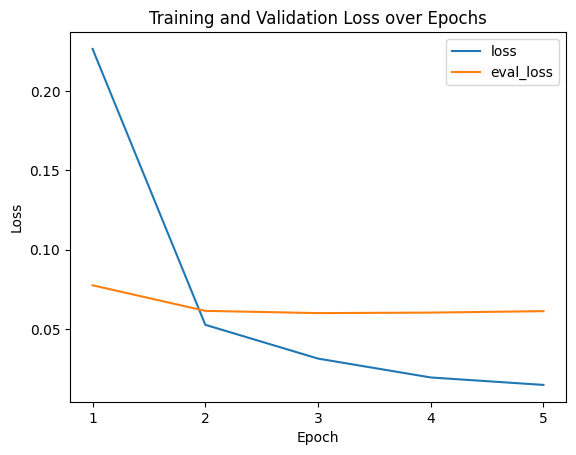

In [43]:
(
    logs[["loss", "eval_loss", "epoch"]]
    .plot(
        kind="line",
        x="epoch", 
        title="Training and Validation Loss over Epochs",
        xlabel="Epoch",
        ylabel="Loss",
        xticks=np.arange(1,6)
    )
)

<Axes: title={'center': 'Validation Metrics over Epochs'}, xlabel='Epoch', ylabel='Score'>

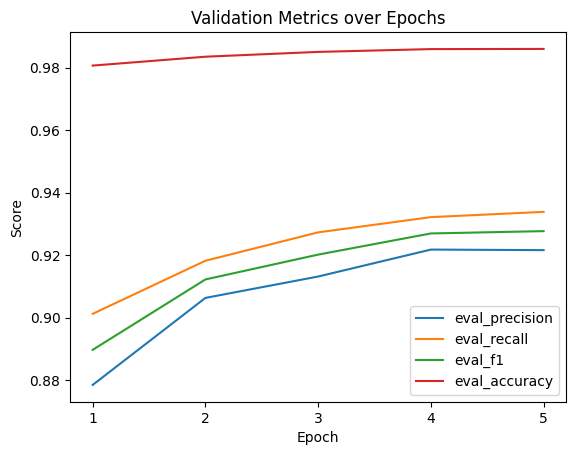

In [44]:
(
    logs[["epoch", "eval_precision", "eval_recall", "eval_f1", "eval_accuracy"]]
    .plot(
        kind="line",
        x="epoch",
        title="Validation Metrics over Epochs",
        xlabel="Epoch",
        ylabel="Score",
        xticks=np.arange(1,6)
    )
)

In [45]:
from transformers import pipeline

checkpoint = 1756 # Checkpoint for epoch 2.
model_dir = f"./models/holding_zone/checkpoint-{checkpoint}"
model = AutoModelForTokenClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
aggregation_strategy = "average"
pipe = pipeline(
    task="token-classification", model=model, tokenizer=tokenizer, aggregation_strategy=aggregation_strategy
)

OSError: Incorrect path_or_model_id: './models/holding_zone/checkpoint-1756'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [ ]:
for index, row in enumerate(tokenized_ds["test"]):
    if index < 5:
        text = " ".join(row["tokens"])
        othertags = [id2label[id] for id in row["ner_tags"]]
        pipe_output = pipe(text)
        print(f"Row: {index}")
        print(f"Transaction: {text}")
        print(f"Actual NER tags: {othertags}")
        for output in pipe_output:
            print(output)
        print("\n")

In [ ]:
from evaluate import evaluator

task_evaluator = evaluator("token-classification")
pipe = pipeline(
    task="token-classification", model=model, tokenizer=tokenizer
)

results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=tokenized_ds["test"],
    metric="seqeval",
    input_column="tokens",
    label_column="ner_tags",
    join_by=" "
)
results

In [ ]:
overall_metrics = { 
    "OVERALL": {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "number": np.NaN
    }
}

keys_to_keep = ["LOC", "MISC", "ORG", "PER"]
metrics = {key: results[key] for key in keys_to_keep if key in results}
metrics.update(overall_metrics)
metrics

In [ ]:
metric_df = (
    pd.DataFrame(metrics)
    .transpose()
)
metric_df

In [ ]:
(
    metric_df
    .drop(["number"], axis=1)
    .plot(
        kind="barh",
        title="Testing Metrics per Entity",
        xlabel="Score"
    )
    .legend(bbox_to_anchor=(1,1))
)

In [ ]:
(
    metric_df["number"]
    .drop('OVERALL')
    .plot(
        kind="barh",
        title="Frequency of each Entity"
    )
)